In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import re

In [6]:
load_dotenv(dotenv_path='../.env')

True

In [7]:
DB_USER = os.getenv("PG_USER")
DB_PASS = os.getenv("PG_PASSWORD")
DB_HOST = os.getenv("PG_HOST")
DB_PORT = os.getenv("PG_PORT")
DB_NAME = os.getenv("PG_DATABASE")

In [8]:
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

In [12]:
df = pd.read_sql_table("grammy_awards", engine)
df.head()

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          4810 non-null   int64 
 1   title         4810 non-null   object
 2   published_at  4810 non-null   object
 3   updated_at    4810 non-null   object
 4   category      4810 non-null   object
 5   nominee       4804 non-null   object
 6   artist        2970 non-null   object
 7   workers       2620 non-null   object
 8   img           3443 non-null   object
 9   winner        4810 non-null   bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 343.0+ KB


Examining the distinct and missing values

While reviewing the data, we found something unusual the winner column contains only a single unique value. We'll investigate this further in a later section.

In [14]:
df.nunique()

year              62
title             62
published_at       4
updated_at        10
category         638
nominee         4131
artist          1658
workers         2366
img             1463
winner             1
dtype: int64

The high number of missing values in artist and workers is quite notable.

 These columns are actually the most significant in our dataset, as they provide the richest information and context to each record. We'll explore potential ways to address their missing values later on.

In [15]:
df.isnull().sum()

year               0
title              0
published_at       0
updated_at         0
category           0
nominee            6
artist          1840
workers         2190
img             1367
winner             0
dtype: int64

Are these columns relevant?

Published At and Updated At columns

During the dataset analysis, I couldn’t identify a meaningful purpose for the values in these two columns. The dates don’t correspond to the event’s actual date or any related commemorative moment. As a result, I’ve decided to remove them from the dataframe.

In [16]:
df["published_at"].value_counts()

published_at
2017-11-28T00:03:45-08:00    4205
2020-05-19T05:10:28-07:00     433
2018-12-06T23:48:49-08:00      86
2018-05-22T03:08:24-07:00      86
Name: count, dtype: int64

In [17]:
df["updated_at"].value_counts()

updated_at
2019-09-10T01:08:19-07:00    778
2019-09-10T01:06:11-07:00    754
2019-09-10T01:07:37-07:00    713
2019-09-10T01:06:59-07:00    681
2019-09-10T01:11:09-07:00    658
2019-09-10T01:09:02-07:00    554
2020-05-19T05:10:28-07:00    433
2017-11-28T00:03:45-08:00    108
2020-09-01T12:16:40-07:00     83
2019-09-10T01:11:48-07:00     48
Name: count, dtype: int64

Image column

We’ll take a look to see whether any of these images are accessible or suitable for use.

In [18]:
df.loc[0, "img"]

'https://www.grammy.com/sites/com/files/styles/artist_circle/public/muzooka/Billie%2BEilish/Billie%2520Eilish_1_1_1594138954.jpg?itok=3-71Dfxh'

Winners column

We observed that this column only contains the value True, even though in some editions, the non-winners in certain categories are also listed.

Due to the limited data, we’re unable to distinguish actual winners from other nominees — unless we incorporate external sources unrelated to the Grammys.

To help identify nominated songs versus non-nominated ones during the merging process, we’ll keep this column but rename it to is_nominated.

In [19]:
df["winner"].value_counts()

winner
True    4810
Name: count, dtype: int64

In [20]:
df.rename(columns={"winner": "is_nominated"}, inplace=True)

In the end, we drop the columns that are not needed.

In [21]:
df = df.drop(columns=["published_at", "updated_at", "img"])

In [22]:
df.head()

,year,title,category,nominee,artist,workers,is_nominated
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",True
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",True
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",True
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",True
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",True


Handling missing values

Nominee

There are only 6 missing entries in the nominee column, which allows us to take a closer look and consider dropping these rows.

After reviewing them, we noticed that none of these null values actually refer to a specific nominee. As such, they don't hold any meaningful information.

In [23]:
df.loc[df["nominee"].isna()]

,year,title,category,nominee,artist,workers,is_nominated
2274,2000,43rd Annual GRAMMY Awards (2000),"Remixer of the Year, Non-Classical",None,None,None,True
2372,1999,42nd Annual GRAMMY Awards (1999),"Remixer Of The Year, Non-Classical",None,None,None,True
2464,1998,41st Annual GRAMMY Awards (1998),"Remixer Of The Year, Non-classical",None,None,None,True
2560,1997,40th Annual GRAMMY Awards (1997),"Remixer Of The Year, Non-Classical",None,None,None,True
4527,1965,8th Annual GRAMMY Awards (1965),Best New Country & Western Artist,None,None,None,True
4574,1964,7th Annual GRAMMY Awards (1964),Best New Country & Western Artist Of 1964,None,None,None,True


In [24]:
df = df.dropna(subset=["nominee"])
df.loc[df["nominee"].isna()]

,year,title,category,nominee,artist,workers,is_nominated


Artist and Workers

To handle the missing values in this case, we’ll explore different scenarios, starting with the one below:

Both Artist and Workers are null
One observation during the analysis is that the workers column, on its own, doesn't offer much analytical value. Still, it's quite useful during the data transformation phase, so we won't remove it beforehand.

In this scenario, we’ll look into the rows where both columns are null. This typically occurs in categories like Best New Artist and Producer Of The Year, where the nominee is also considered the artist. Based on that, it makes sense to use the nominee’s name as the artist.

Let’s check which cases allow for this assumption by examining the values in the category column.

In [25]:
both_null_values = df.loc[df["artist"].isna() & df["workers"].isna()]
both_null_values.head()

,year,title,category,nominee,artist,workers,is_nominated
24,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Billie Eilish,None,None,True
25,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Black Pumas,None,None,True
26,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Lil Nas X,None,None,True
27,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Lizzo,None,None,True
28,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Maggie Rogers,None,None,True


In [26]:
both_null_values["category"].value_counts()

category
Best New Artist                                                                              50
Producer Of The Year, Non-Classical                                                          22
Producer Of The Year, Classical                                                              22
Classical Producer Of The Year                                                               18
Producer Of The Year (Non-Classical)                                                         10
Producer Of The Year                                                                         10
Best New Artist Of The Year                                                                   9
Best Classical Vocal Soloist Performance                                                      7
Best Classical Vocal Performance                                                              4
Best Small Ensemble Performance (With Or Without Conductor)                                   4
Best Classical Performance - In

Let’s take a look at some categories where the data may not be particularly valuable or relevant for our purposes.

In [27]:
categories = [
    "Best Classical Vocal Soloist Performance",
    "Best Classical Vocal Performance",
    "Best Small Ensemble Performance (With Or Without Conductor)",
    "Best Classical Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)",
    "Most Promising New Classical Recording Artist",
    "Best Classical Performance - Vocal Soloist (With Or Without Orchestra)",
    "Best New Classical Artist",
    "Best Classical Vocal Soloist",
    "Best Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)",
    "Best Classical Performance - Vocal Soloist"
]

both_filtered = both_null_values[both_null_values["category"].isin(categories)]
both_filtered.head()

,year,title,category,nominee,artist,workers,is_nominated
2382,1999,42nd Annual GRAMMY Awards (1999),Best Small Ensemble Performance (With Or Witho...,"Colors Of Love - Works Of Thomas, Stucky, Tave...",None,None,True
2475,1998,41st Annual GRAMMY Awards (1998),Best Small Ensemble Performance (With Or Witho...,Reich: Music For 18 Musicians,None,None,True
2570,1997,40th Annual GRAMMY Awards (1997),Best Small Ensemble Performance (With Or Witho...,"Hindemith: Kammermusik No. 1 With Finale 1921,...",None,None,True
2571,1997,40th Annual GRAMMY Awards (1997),Best Classical Vocal Performance,"An Italian Songbook - Works Of Bellini, Donize...",None,None,True
2658,1996,39th Annual GRAMMY Awards (1996),Best Small Ensemble Performance (With Or Witho...,Boulez: ...Explosante-Fixe...,None,None,True


After reviewing the previous output, our suspicion is confirmed:

 most of the nominee values in these categories aren’t helpful for extracting artist information. Therefore, we’ll go ahead and remove them.

In [28]:
both_null_values = both_null_values.drop(both_filtered.index, axis=0)
df = df.drop(both_filtered.index, axis=0)

In [30]:
df.shape

(4776, 7)

At this point, we can transfer the values from nominee to artist for the relevant cases we identified earlier.

In [31]:
df.loc[both_null_values.index, "artist"] = both_null_values["nominee"]

In [32]:
df.loc[df["artist"].isna() & df["workers"].isna()]

,year,title,category,nominee,artist,workers,is_nominated


Artist appears within workers

Some rows in the dataset have missing values in the artist column, but the artist’s name is actually included in parentheses within the workers field, as shown in the following outputs:

In [33]:
artist_null = df.loc[df["artist"].isna()]
artist_null.shape

(1654, 7)

In [34]:
artist_null_sample = artist_null.head()
artist_null_sample

,year,title,category,nominee,artist,workers,is_nominated
16,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Bad Guy,None,"Billie Eilish O'Connell & Finneas O'Connell, s...",True
17,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Always Remember Us This Way,None,"Natalie Hemby, Lady Gaga, Hillary Lindsey & Lo...",True
18,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Bring My Flowers Now,None,"Brandi Carlile, Phil Hanseroth, Tim Hanseroth ...",True
19,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Hard Place,None,"Ruby Amanfu, Sam Ashworth, D. Arcelious Harris...",True
20,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Lover,None,"Taylor Swift, songwriter (Taylor Swift)",True


In [35]:
for i in artist_null_sample.index:
    print(artist_null_sample.loc[i, "workers"])

Billie Eilish O'Connell & Finneas O'Connell, songwriters (Billie Eilish)
Natalie Hemby, Lady Gaga, Hillary Lindsey & Lori McKenna, songwriters (Lady Gaga)
Brandi Carlile, Phil Hanseroth, Tim Hanseroth & Tanya Tucker, songwriters (Tanya Tucker)
Ruby Amanfu, Sam Ashworth, D. Arcelious Harris, H.E.R. & Rodney Jerkins, songwriters (H.E.R.)
Taylor Swift, songwriter (Taylor Swift)


The code below fills in the missing values in the artist column using relevant information extracted from workers, helping to keep the dataset consistent and coherent.

This code follows a logical sequence to ensure that:

Existing values in the artist column are preserved when they’re not null.

Any missing values in artist are filled using the text found in parentheses from the workers column, if such text exists.

Ultimately, it returns a DataFrame with a more accurate and complete artist column, enhanced using details pulled from workers.

In [37]:
def extract_artist(workers):
    match = re.search(r'\((.*?)\)', workers)
    if match:
        return match.group(1)
    return None

df["artist"] = (df.apply
    (lambda row:
        extract_artist(row["workers"])
        if pd.isna(row["artist"])
            else row["artist"], axis=1))

In [38]:
df.iloc[16:20]

,year,title,category,nominee,artist,workers,is_nominated
16,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Bad Guy,Billie Eilish,"Billie Eilish O'Connell & Finneas O'Connell, s...",True
17,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Always Remember Us This Way,Lady Gaga,"Natalie Hemby, Lady Gaga, Hillary Lindsey & Lo...",True
18,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Bring My Flowers Now,Tanya Tucker,"Brandi Carlile, Phil Hanseroth, Tim Hanseroth ...",True
19,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Hard Place,H.E.R.,"Ruby Amanfu, Sam Ashworth, D. Arcelious Harris...",True


Let’s verify the current count of missing values in our dataframe. Although there’s been a significant decrease, a considerable amount of null data still remains.

In [39]:
df.isna().sum()

year               0
title              0
category           0
nominee            0
artist           288
workers         2156
is_nominated       0
dtype: int64

Several artists still show up in the workers column.

However, we now notice new patterns that can help us identify them:

The name appears by itself or alongside a Featuring, which should also be included.

The name is separated by a semicolon (;) and may be alone or followed by a Featuring, which also needs to be captured.

The artist's name is followed by a comma and a role, such as artist, composer, conductor, choir director, chorus master, ensembles, soloist, or conductor/soloist.

In [40]:
artist_null = df[df["artist"].isna()]
artist_null.head()

,year,title,category,nominee,artist,workers,is_nominated
163,2015,58th Annual GRAMMY Awards (2015),Best Contemporary Classical Composition,Paulus: Prayers & Remembrances,None,"Stephen Paulus, composer",True
164,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Sozinho,None,"Randy Brecker, soloist",True
165,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Elsewhere,None,"Melissa Aldana, soloist",True
166,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Tomorrow Is The Question,None,"Julian Lage, soloist",True
167,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,The Windup,None,"Branford Marsalis, soloist",True


Let’s identify and review the different roles that are present.

In [41]:
artist_index = artist_null.index

In [44]:
roles = (artist_null["workers"]
         .dropna()
         .apply(
             lambda x: 
                 [role.strip() 
                  for role in re.split(r'[;,]', x)[1:]]))

roles_flat = ([role 
               for sublist in roles 
                for role in sublist])

role_counts = Counter(roles_flat)

role_counts.most_common()

[('artist', 80),
 ('producer', 73),
 ('soloist', 63),
 ('composer', 45),
 ('artists', 34),
 ('conductor', 27),
 ('engineer', 19),
 ('songwriters', 13),
 ('engineer/mixer', 10),
 ('producers', 9),
 ('Andreas Neubronner', 6),
 ('Tim Handley', 5),
 ('ensembles', 5),
 ('James Mallinson', 5),
 ('Thomas Frost', 4),
 ('Kirk Franklin', 3),
 ('songwriter', 3),
 ('soloists', 3),
 ('Karl-August Naegler', 3),
 ('Jonathan Allen', 2),
 ('John Newton', 2),
 ('engineers/mixers', 2),
 ('Christopher Alder', 2),
 ('Judith Sherman', 2),
 ('Adam Abeshouse', 2),
 ('Michelle DeYoung', 2),
 ('Hans Weber', 2),
 ('Robert Woods', 2),
 ('Lynn Harrell & Itzhak Perlman', 2),
 ('Artur Rubinstein & Henryk Szeryng', 2),
 ('David Harvey', 2),
 ('Thomas Z. Shepard', 2),
 ('Gregor Piatigorsky & William Primrose', 2),
 ('Bryan Fowler', 1),
 ('Gloria Gaynor & Chris Stevens', 1),
 ('Tony Brown', 1),
 ('Brandon Lake', 1),
 ('Tasha Cobbs Leonard & Nate Moore', 1),
 ('Josh Kerr', 1),
 ('Jordan Reynolds', 1),
 ('Joel Smallbone'

Roles of interest

In [45]:
roles_of_interest = ["artist",
                     "artists",
                     "composer",
                     "conductor",
                     "conductor/soloist",
                     "choir director",
                     "chorus master",
                     "graphic designer",
                     "soloist",
                     "soloists",
                     "ensembles"]

Process solo artists (including those with Featuring credits)

In [46]:
def move_workers_to_artist(row):
    if pd.isna(row["artist"]):
        workers = row["workers"]
        if not re.search(r'[;,]', workers):
            return workers
    return row["artist"]

df["artist"] = df.apply(move_workers_to_artist, axis=1)

In [47]:
new_artists = df.loc[artist_index]
new_artists.loc[[192, 193, 402, 403]]

,year,title,category,nominee,artist,workers,is_nominated
192,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,See The Light,Travis Greene Featuring Jekalyn Carr,Travis Greene Featuring Jekalyn Carr,True
193,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,Speak The Name,Koryn Hawthorne Featuring Natalie Grant,Koryn Hawthorne Featuring Natalie Grant,True
402,2019,62nd Annual GRAMMY Awards (2019),Best Chamber Music/Small Ensemble Performance,Shaw: Orange,Attacca Quartet,Attacca Quartet,True
403,2019,62nd Annual GRAMMY Awards (2019),Best Chamber Music/Small Ensemble Performance,Cerrone: The Pieces That Fall To Earth,Christopher Rountree & Wild Up,Christopher Rountree & Wild Up,True


In [48]:
artist_null = df[df["artist"].isna()]
artist_index = artist_null.index

Handling semicolons

In [49]:
def extract_artists_before_semicolon(workers, roles):
    parts = workers.split(';')
    first_part = parts[0].strip()
    if ',' not in first_part and not any(role in first_part for role in roles):
        return first_part
    return None

df["artist"] = df.apply(
    lambda row: extract_artists_before_semicolon(row["workers"], roles_of_interest) if pd.isna(row["artist"]) else row["artist"],
    axis=1
)

In [50]:
new_artists = df.loc[artist_index]
new_artists.loc[[190, 191, 196, 197]]

,year,title,category,nominee,artist,workers,is_nominated
190,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,Love Theory,Kirk Franklin,"Kirk Franklin; Kirk Franklin, songwriter",True
191,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,Talkin' 'Bout Jesus,Gloria Gaynor Featuring Yolanda Adams,Gloria Gaynor Featuring Yolanda Adams; Bryan F...,True
196,2019,62nd Annual GRAMMY Awards (2019),Best Contemporary Christian Music Performance/...,Only Jesus,Casting Crowns,"Casting Crowns; Mark Hall, Bernie Herms & Matt...",True
197,2019,62nd Annual GRAMMY Awards (2019),Best Contemporary Christian Music Performance/...,Haven't Seen It Yet,Danny Gokey,"Danny Gokey; Danny Gokey, Ethan Hulse & Colby ...",True


In [51]:
artist_null = df[df["artist"].isna()]
artist_index = artist_null.index

Handling commas

In [52]:
def extract_roles_based_on_interest(workers, roles):
    pattern = r'([^;]+)\s*(?:,\s*(?:' + '|'.join(roles) + r'))'
    matches = re.findall(pattern, workers)
    return ", ".join(matches).strip() if matches else None

df["artist"] = df.apply(
    lambda row: extract_roles_based_on_interest(row["workers"], roles_of_interest) if pd.isna(row["artist"]) else row["artist"],
    axis=1
)

In [53]:
new_artists = df.loc[artist_index]
new_artists.head()

,year,title,category,nominee,artist,workers,is_nominated
163,2015,58th Annual GRAMMY Awards (2015),Best Contemporary Classical Composition,Paulus: Prayers & Remembrances,Stephen Paulus,"Stephen Paulus, composer",True
164,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Sozinho,Randy Brecker,"Randy Brecker, soloist",True
165,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Elsewhere,Melissa Aldana,"Melissa Aldana, soloist",True
166,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Tomorrow Is The Question,Julian Lage,"Julian Lage, soloist",True
167,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,The Windup,Branford Marsalis,"Branford Marsalis, soloist",True


In [54]:
df.isna().sum()

year               0
title              0
category           0
nominee            0
artist             5
workers         2156
is_nominated       0
dtype: int64

Since the entries here only include producers and engineers/mixers—and none of the previously selected categories—we can go ahead and remove these rows.

In [55]:
artist_null = df.loc[df["artist"].isnull()]
artist_null

,year,title,category,nominee,artist,workers,is_nominated
777,2015,58th Annual GRAMMY Awards (2015),Best Chamber Music/Small Ensemble Performance,Filament,None,"Bryce Dessner, producer; Jonathan Low, engineer",True
861,2014,57th Annual GRAMMY Awards (2014),Best Chamber Music/Small Ensemble Performance,In 27 Pieces - The Hilary Hahn Encores,None,"Hilary Hahn & Andreas K. Meyer, producers; And...",True
1869,2004,47th Annual GRAMMY Awards (2004),Best Chamber Music Performance,Prokofiev (Arr. Pletnev): Cinderella - Suite F...,None,"Christian Gansch, producer; Rainer Maillard, e...",True
2182,2001,44th Annual GRAMMY Awards (2001),Best Small Ensemble Performance (with or witho...,"After Mozart - Raskatov, Silvestrov & Schnittke",None,"Gidon Kremer & Helmut Mühle, producers; Philip...",True
2285,2000,43rd Annual GRAMMY Awards (2000),Best Small Ensemble Performance (with or witho...,"Shadow Dances - Stravinsky Miniatures, Tango, ...",None,"Christian Gansch, producer; Wolf-Dieter Karwat...",True


In [56]:
df = df.dropna(subset=["artist"])

Additionally, 
as previously mentioned, we’re going to drop the workers column, since its only purpose was to assist with the transformations applied to the artist column.

In [57]:
df = df.drop(columns=["workers"])

In [58]:

df.head()

,year,title,category,nominee,artist,is_nominated
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,True
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,True
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,True
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,True
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,True


In [59]:
df["artist"].value_counts()

artist
(Various Artists)                                          66
Various Artists                                            43
Chicago Symphony Orchestra                                 29
John Williams                                              24
Henry Mancini                                              22
                                                           ..
Norman Luboff Choir                                         1
Royal Philharmonic Chorus; Royal Philharmonic Orchestra     1
Aaron Copland                                               1
Frank Sinatra And Original Cast                             1
Mary Martin And Original Broadway Cast                      1
Name: count, Length: 2463, dtype: int64

let's try to replace the value "(Various Artists)" in column "artist" for "Various Artists"

In [60]:
df["artist"] = df["artist"].replace({"(Various Artists)": "Various Artists"})

In [61]:
df["artist"].value_counts()

artist
Various Artists                                            109
Chicago Symphony Orchestra                                  29
John Williams                                               24
Henry Mancini                                               22
Vladimir Horowitz                                           20
                                                          ... 
Norman Luboff Choir                                          1
Royal Philharmonic Chorus; Royal Philharmonic Orchestra      1
Aaron Copland                                                1
Frank Sinatra And Original Cast                              1
Mary Martin And Original Broadway Cast                       1
Name: count, Length: 2462, dtype: int64

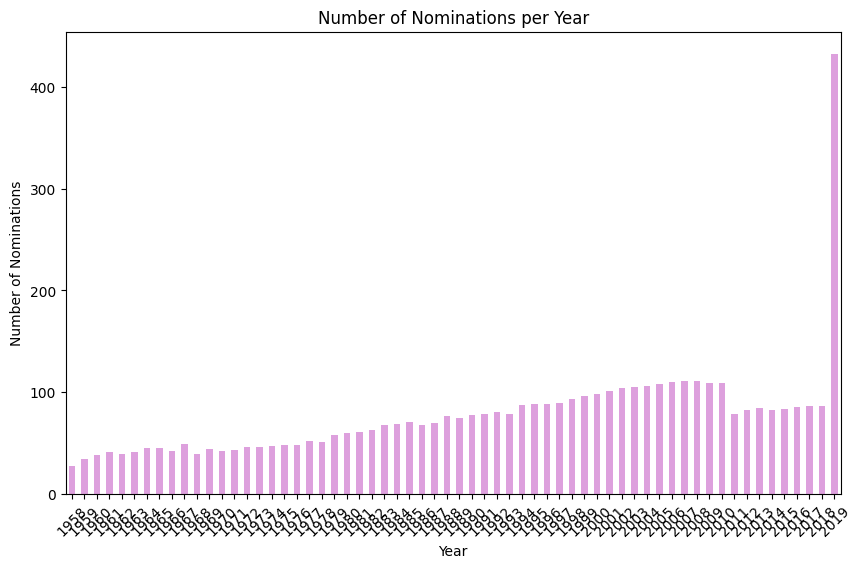

In [63]:
nominations_per_year = df["year"].value_counts().sort_index()

plt.figure(figsize=(10, 6))

nominations_per_year.plot(kind="bar", color="plum")

plt.title("Number of Nominations per Year")
plt.xlabel("Year")
plt.ylabel("Number of Nominations")

plt.xticks(rotation=45)

plt.show()

Try again but whit this transformation

In [64]:
awarded_data = df.copy()

In [65]:
awarded_data["decade"] = (awarded_data["year"] // 10) * 10
awarded_data

,year,title,category,nominee,artist,is_nominated,decade
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,True,2010
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,True,2010
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,True,2010
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,True,2010
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,True,2010
...,...,...,...,...,...,...,...
4804,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Orchestra,Gaiete Parisienne,Hollywood Bowl Orchestra,True,1950
4805,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Instrumentalist (...,Tchaikovsky: Piano Concerto No. 1 In B Flat Mi...,Symphony Of The Air Orchestra,True,1950
4806,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Instrumentalist (...,Segovia Golden Jubilee,Andres Segovia,True,1950
4807,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Chamber Music (In...,Beethoven: Quartet 130,"Alvin Dinkin, Paul Shure, Eleanor Aller Slatki...",True,1950


Now this looks better

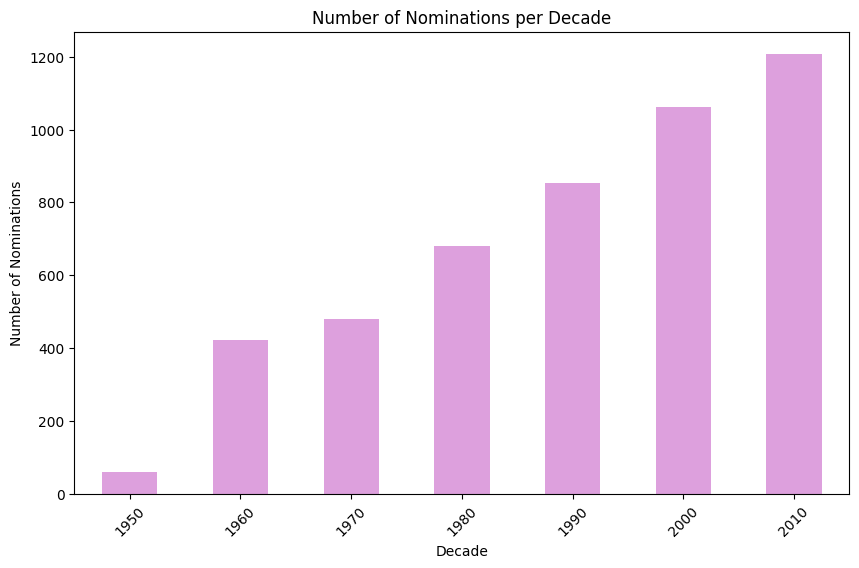

In [66]:
nominations_per_decade = awarded_data["decade"].value_counts().sort_index()

plt.figure(figsize=(10, 6))

nominations_per_decade.plot(kind="bar", color="plum")

plt.title("Number of Nominations per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Nominations")

plt.xticks(rotation=45)

plt.show()

Top Nominated Artists by Decade

The chart reveals that some artists consistently stood out in specific time periods. For example, Michael Jackson was the most nominated artist in the 1980s, whereas Adele took the lead in the 2010s. This analysis underscores how artists' prominence and industry recognition can shift greatly from decade to decade.

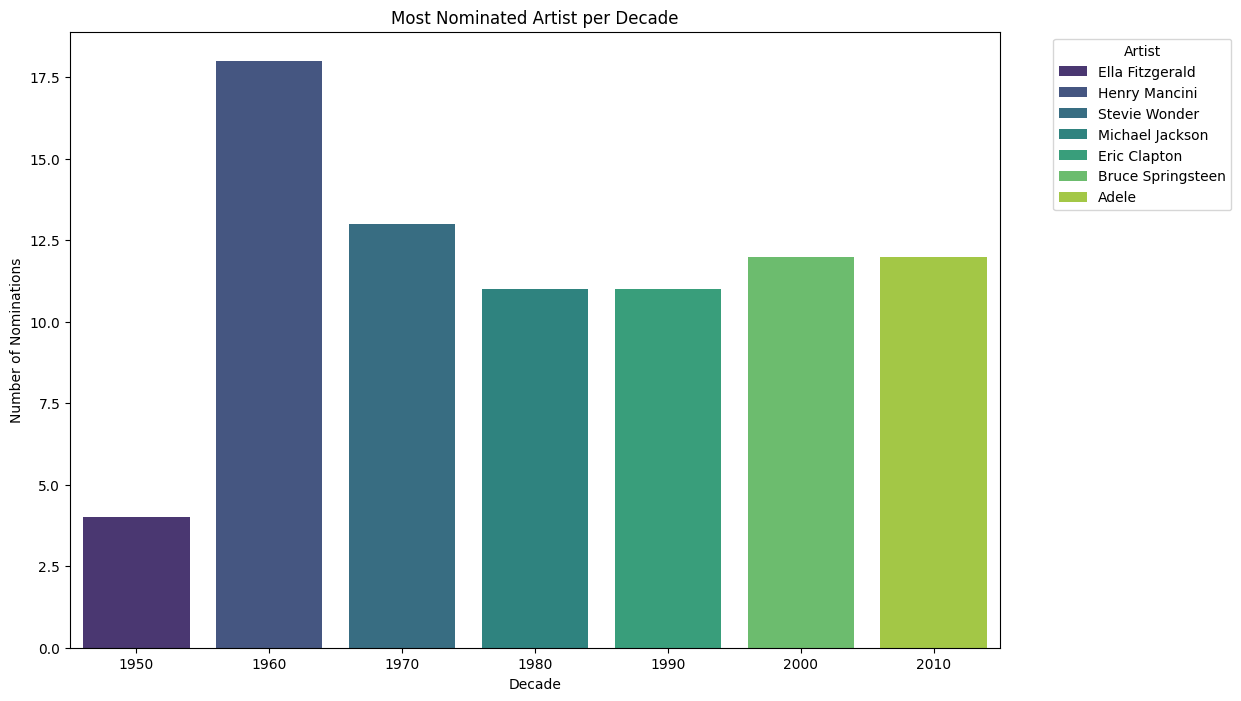

In [67]:
filtered_awarded_data = awarded_data[awarded_data["artist"] != "Various Artists"]

most_nominated_per_decade = (filtered_awarded_data.groupby(["decade", "artist"])
                             .size()
                             .reset_index(name="count")
                             .sort_values(["decade", "count"], ascending=[True, False])
                             .drop_duplicates(subset=["decade"]))

plt.figure(figsize=(12, 8))

sns.barplot(x="decade",
            y="count",
            hue="artist",
            dodge=False,
            data=most_nominated_per_decade,
            palette="viridis")

plt.title("Most Nominated Artist per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Nominations")
plt.legend(title="Artist", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

In [ ]:
df['artist'].to_csv('../Data/artist.csv', index=False)